# 0 - Imports

In [1]:
#import libraries
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
import xgboost as xgb
import seaborn as sns
from utils import metric, my_data_preparation

# 1 - Data Preparation

In [2]:
#ask user for the address of the holdout file
holdout_path = input("Enter the address for the holdout file:")
#list of features
features =  ['Store', 'DayOfWeek', 'WeekOfYear', 'Month', 'Open', 'Promo', 'SchoolHoliday', 
             'CompetitionDistance', 'Promo2', 
             'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
             'Assortment_a', 'Assortment_b', 'Assortment_c',
             'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']
test_features =  ['Store', 'DayOfWeek', 'WeekOfYear', 'Month', 'Open', 'Promo', 'SchoolHoliday', 
             'CompetitionDistance', 'Promo2', 
             'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
             'Assortment_a', 'Assortment_b', 'Assortment_c',
             'StateHoliday_0', 'StateHoliday_a']
#list of features and target, the target is 'Sales'
features_and_target = list(features)
features_and_target.append('Sales')
#load data files
store_data = pd.read_csv("./data/store.csv")
train_data = pd.read_csv("./data/train.csv")
holdout_data_0 = pd.read_csv(holdout_path)
all_holdout_data = my_data_preparation(holdout_data_0,store_data)
all_holdout_data["Sales"] = None
#all_holdout_data = all_holdout_data.dropna(axis = 0, subset = list(test_features))
#all_holdout_data = all_holdout_data.drop(columns=['Sales'])

#prepare the data
all_data = my_data_preparation(train_data,store_data)
#drop all rows with nans in the relevant columns
numeric_data = all_data.dropna(axis = 0, subset = features_and_target)
#drop all rows with vanishing sales
numeric_data = numeric_data.loc[numeric_data['Sales'] != 0.0]
data = numeric_data
#specify target and features
y = data.loc[:, 'Sales']
X = data.loc[:, features]
#set up the target encoder
#we target encode only the 'Store' column
ce_te = ce.TargetEncoder(cols = 'Store')
#find transform for target encoding
ce_te.fit(X, y)
#transform features
X = ce_te.transform(X)
#split into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

#specify features for the holdout data
holdout_data = all_holdout_data.loc[:, test_features]
holdout_data['StateHoliday_b'] = 0
holdout_data['StateHoliday_c'] = 0

#transform the holdout data
X_holdout = ce_te.transform(holdout_data)

#XGBoost regression
#set up xgb regressor

Enter the address for the holdout file: ./data/test.csv


/var/folders/fc/x2d068991279ggyl9j3v3h9w0000gn/T/ipykernel_31164/4038981000.py:19: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("./data/train.csv")
/Users/hussami/miniforge3/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1204: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


## 2 - Prediction Model: XGBoost 

In [3]:
xgbr = xgb.XGBRegressor(max_depth=250,learning_rate=0.2,n_estimators=150,n_jobs=10, 
                        colsample_bytree=0.4,subsample=0.7,reg_alpha=10,reg_lambda=20)
#fit the training data
xgbr.fit(X_train, y_train)
#xgb prediction on the test data
predict_test = xgbr.predict(X_test)
#xgb prediction on the test data
predict_train = xgbr.predict(X_train)

#xgb prediction for the holdout data
predict_holdout = xgbr.predict(X_holdout)
#compute xgb holdout RMSPE
diff = 1 - predict_test/y_test
RMSPE = sqrt(np.dot(diff,diff)/len(diff))
print(f'RMSPE: {RMSPE}')

RMSPE: 0.1693426665988216


# 3 - Writing out Results to csv

In [ ]:
df = pd.DataFrame(predict_holdout)
h=pd.read_csv("test.csv").iloc[:,[0]]

df = pd.concat([h, df],axis=1)
df=df.rename({"Unnamed: 0":'Id',0:'Sales'},axis=1)

df.Id=df.Id+1
df = df.dropna()

df.to_csv("./data/results_kaggle_rossman_2.csv")
#df.to_csv("hold2.csv",index=False)
#df.to_csv("./data/results_kaggle_rossman_2.csv")

# 4 - Results and Error analysis 

## 4.1 - Real vs Prediction

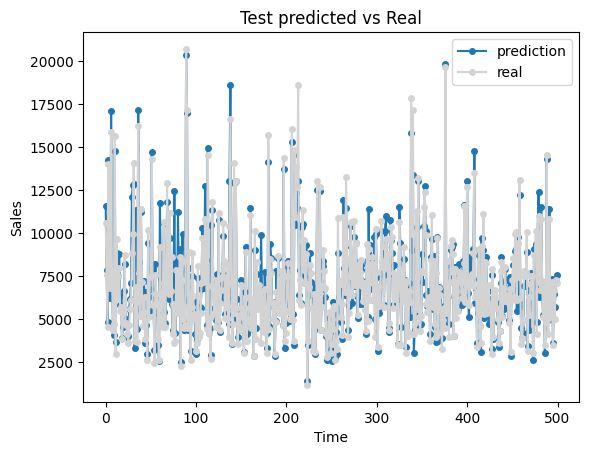

In [141]:
axe = [i for i in range(len(predz))]

plt.plot(predz[:500], label="prediction",linewidth=1.5,marker="o",
                 linestyle="-",
                 markersize=4)
plt.plot(axe[:500],y_test[:500],label="real",linewidth=1.5,marker="o",
                 linestyle="-",
                 markersize=4,color="lightgrey")
plt.title("Test predicted vs Real")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.show()

## 4.2 - Feature correlation

<Axes: >

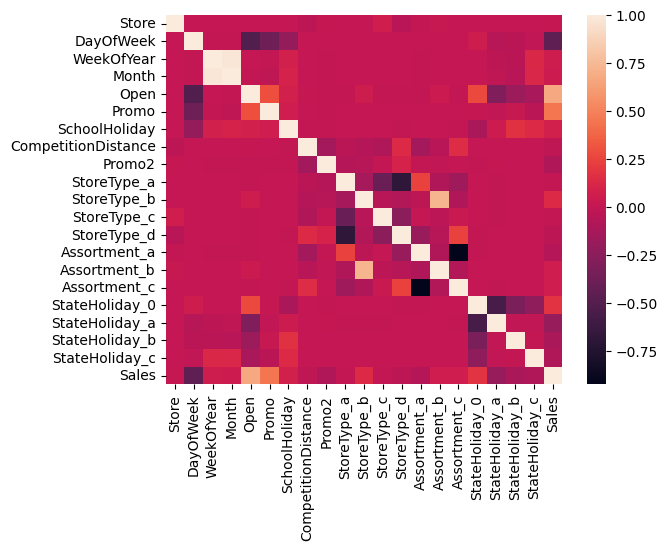

In [76]:
sns.heatmap(all_data[features_and_target].corr())

## 4.3 - Exploring error by store type

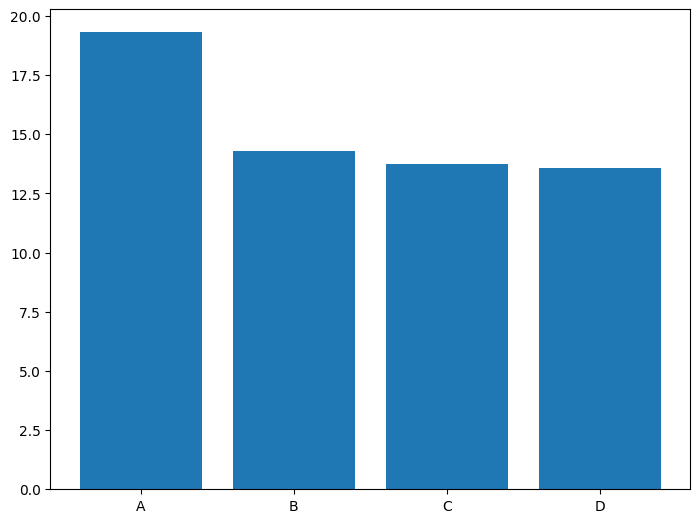

In [77]:
X_test['Prediction']=predict_test
X_test['Sales']=y_test
test_results=X_test
Store_a = test_results[test_results.StoreType_a == 1]
Store_b = test_results[test_results.StoreType_b == 1]
Store_c = test_results[test_results.StoreType_c == 1]
Store_d = test_results[test_results.StoreType_d == 1]

error_Sa=100*metric(Store_a.iloc[:,-2],Store_a.Sales)
error_Sb=100*metric(Store_b.iloc[:,-2],Store_b.Sales)
error_Sc=100*metric(Store_c.iloc[:,-2],Store_c.Sales)
error_Sd=100*metric(Store_d.iloc[:,-2],Store_d.Sales)
errorz=[error_Sa,error_Sb,error_Sc,error_Sd]
#error_by_storetype={“A”:error_Sa,“B”:error_Sb,“C”:error_Sc,“D”:error_Sd}
error_by_storetype = ["A","B","C","D"]
Store_a_train = X_train[X_train.StoreType_a == 1]
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
ax.bar(error_by_storetype, errorz)
plt.show()